In [3]:
#-- import modules --

import numpy as np
import matplotlib.pyplot as plt
from extract_noise_psds import extract_noise_psds
from rbf_pe_utils_LIGO_India import generate_sim_data
import pycbc
from pycbc.detector import add_detector_on_earth

In [4]:
noise_case = 1200

### $\Rightarrow$ For L1V1 network

In [5]:
#-- Extracting the real noise from interferometers and evaluating their corresponding PSDs --

event = 'GW190425'
ifos = ['L1', 'V1']
initial_gap = noise_case
raw_duration = 372
A0_gap = 100
A0_noise_det = 'V1'
highpass_cutoff = 18
filter_order = 4
crop_len = 6
psd_segLen=2
psd_estimate_method='median-mean'
low_frequency_cutoff= 20


noise, noise_tilde, psd = extract_noise_psds(event, ifos, initial_gap, raw_duration, A0_gap,\
                                             A0_noise_det, highpass_cutoff, filter_order, crop_len,\
                                             psd_segLen, psd_estimate_method, low_frequency_cutoff, save_to_hdf=True)


In [6]:
#-- Generating a GW170817 like data with signal embedded in real noise --

# tc is taken such that it is 30 secs before end_time for L1 noise
trigTime = float(noise["L1"].end_time) - 30   


inject_params = {'m1_det': 1.759,  #detector frame mass_1, taken from MAP values of (mass_1) GW190425 posterior samples
                 'm2_det': 1.654,  #detector frame mass_2,taken from MAP values (mass_2) of GW190425 posterior samples 
                 'spin_1z': 0.0011, #spin_1z, taken from MAP values (spin_1z) of GW190425 posterior samples
                 'spin_2z': 0.0019, #spin_2z, taken from MAP values (spin_1z) of GW190425 posterior samples
                 'luminosity_distance': 170.99,   #taken from MAP values (luminosity_distance) of GW190425 posterior samples
                 'iota': 0.583,       # taken from MAP value (iota) of GW190425 posterior samples
                 'ra': 4.338,         # taken from MAP value (ra) of GW190425 posterior samples
                 'dec': -0.254,       # taken from MAP value (dec) of GW190425 posterior samples
                 'pol':0,             # taken from MAP value (psi) of GW190425 posterior samples
                 'tc': trigTime}   # tc is taken such that it is 30 secs before end_time for L1 noise

#-- injection_approximant --

inj_approx = 'IMRPhenomD'

#-- injection_params array --

inj_params = np.array([inject_params['m1_det'], inject_params['m2_det'],\
                       inject_params['spin_1z'], inject_params['spin_2z'],\
                       inject_params['iota'], inject_params['luminosity_distance'],\
                       inject_params['ra'], inject_params['dec'],\
                       inject_params['pol'], inject_params['tc']])


fLow, fHigh = 20, 1600

low_frequency_cutoff, high_frequency_cutoff = 20, 1600   #(need to remove to optimize the code)

sampling_frequency = 4096       # Hz
segLen = 360                    # secs   (will also be used in start_up function)


#-- calling the 'generate_sim_data' function from 'rbf_pe_utils' --

data = generate_sim_data(inj_approx=inj_approx, fLow=fLow, segLen=segLen, ifos=ifos, inj_params=inj_params,\
                         noise_tilde=noise_tilde, psd=psd)


In [7]:
# for matched filter

approximant = 'TaylorF2'

hp, hc = pycbc.waveform.get_fd_waveform(approximant=approximant, mass1=inject_params['m1_det'],\
                                        mass2=inject_params['m2_det'], spin1z=inject_params['spin_1z'],\
                                        spin2z=inject_params['spin_2z'], f_lower=fLow, f_final=fHigh,\
                                        delta_f=1/segLen)

hp.resize(len(data['L1']))

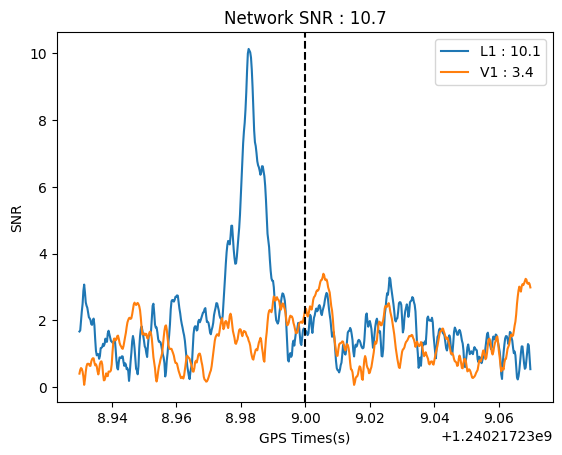

In [8]:
snrs={}
snrs_vals = {}
network_snr = 0

for ifo in ifos:
    
    snrs[ifo] = pycbc.filter.matched_filter(hp, data[ifo], psd=psd[ifo],\
                                            low_frequency_cutoff=fLow, high_frequency_cutoff=fHigh)
    

   #-- around 70 ms from trigger time --
    snrs[ifo] = snrs[ifo].time_slice(start=inject_params['tc'] - 0.07, end=inject_params['tc'] + 0.07)
    
    snrs_vals[ifo] = abs(snrs[ifo]).max()
    
    network_snr += (snrs_vals[ifo])**2
    
    
network_snr = np.sqrt(network_snr)

for ifo in ifos:
    
    plt.plot(snrs[ifo].sample_times, abs(snrs[ifo]), label='%s : %.1f'%(ifo, abs(snrs[ifo]).max()))
   # plt.xlim(inject_params['tc'] - 0.15, inject_params['tc'] + 0.15)

plt.title('Network SNR : %.1f'%network_snr)
plt.xlabel('GPS Times(s)')
plt.axvline(trigTime, ls='--', c='k')
plt.ylabel('SNR')
plt.legend()
#plt.savefig("SNR_4Det_network_test2.jpg", dpi=200, bbox_inches='tight')
plt.show()

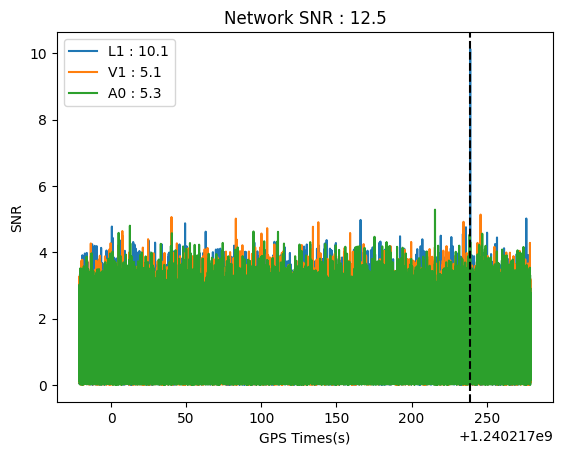

In [28]:
#-- Mistake in SNR calculation --

snrs={}
network_snr = 0

for ifo in ifos:
    
    snrs[ifo] = pycbc.filter.matched_filter(hp, data[ifo], psd=psd[ifo],\
                                            low_frequency_cutoff=fLow, high_frequency_cutoff=fHigh)
    

    snrs[ifo] = snrs[ifo].crop(50,10)
    
    network_snr += (abs(snrs[ifo])**2).max()
    
    
network_snr = np.sqrt(network_snr)

for ifo in ifos:
    
    plt.plot(snrs[ifo].sample_times, abs(snrs[ifo]), label='%s : %.1f'%(ifo, abs(snrs[ifo]).max()))
   # plt.xlim(inject_params['tc'] - 0.15, inject_params['tc'] + 0.15)

plt.title('Network SNR : %.1f'%network_snr)
plt.xlabel('GPS Times(s)')
plt.axvline(trigTime, ls='--', c='k')
plt.ylabel('SNR')
plt.legend()
#plt.savefig("SNR_4Det_network_test2.jpg", dpi=200, bbox_inches='tight')
plt.show()

## $\Rightarrow$ For L1V1A0 network

In [9]:
#-- adding LIGO India to PyCBC detectors --

add_detector_on_earth(name='A0', longitude=1.34444215058, latitude=0.34231676739,\
                      yangle=4.23039066080, xangle=5.80120119264, height=440) 


In [10]:
#-- Extracting the real noise from interferometers and evaluating their corresponding PSDs --

event = 'GW190425'
ifos = ['L1','V1', 'A0']
initial_gap = noise_case
raw_duration = 372
A0_gap = 100
A0_noise_det = 'V1'
highpass_cutoff = 18
filter_order = 4
crop_len = 6
psd_segLen=2
psd_estimate_method='median-mean'
low_frequency_cutoff= 20


noise, noise_tilde, psd = extract_noise_psds(event, ifos, initial_gap, raw_duration, A0_gap,\
                                             A0_noise_det, highpass_cutoff, filter_order, crop_len,\
                                             psd_segLen, psd_estimate_method, low_frequency_cutoff, save_to_hdf=True)


In [11]:
#-- Generating a GW170817 like data with signal embedded in real noise --

# tc is taken such that it is 30 secs before end_time for L1 noise
trigTime = float(noise["L1"].end_time) - 30   


inject_params = {'m1_det': 1.759,  #detector frame mass_1, taken from MAP values of (mass_1) GW190425 posterior samples
                 'm2_det': 1.654,  #detector frame mass_2,taken from MAP values (mass_2) of GW190425 posterior samples 
                 'spin_1z': 0.0011, #spin_1z, taken from MAP values (spin_1z) of GW190425 posterior samples
                 'spin_2z': 0.0019, #spin_2z, taken from MAP values (spin_1z) of GW190425 posterior samples
                 'luminosity_distance': 170.99,   #taken from MAP values (luminosity_distance) of GW190425 posterior samples
                 'iota': 0.583,       # taken from MAP value (iota) of GW190425 posterior samples
                 'ra': 4.338,         # taken from MAP value (ra) of GW190425 posterior samples
                 'dec': -0.254,       # taken from MAP value (dec) of GW190425 posterior samples
                 'pol':0,             # taken from MAP value (psi) of GW190425 posterior samples
                 'tc': trigTime}   # tc is taken such that it is 30 secs before end_time for L1 noise


#-- injection_approximant --

inj_approx = 'IMRPhenomD'

#-- injection_params array --

inj_params = np.array([inject_params['m1_det'], inject_params['m2_det'],\
                       inject_params['spin_1z'], inject_params['spin_2z'],\
                       inject_params['iota'], inject_params['luminosity_distance'],\
                       inject_params['ra'], inject_params['dec'],\
                       inject_params['pol'], inject_params['tc']])


fLow, fHigh = 20, 1600

low_frequency_cutoff, high_frequency_cutoff = 20, 1600   #(need to remove to optimize the code)

sampling_frequency = 4096       # Hz
segLen = 360                    # secs   (will also be used in start_up function)


#-- calling the 'generate_sim_data' function from 'rbf_pe_utils' --

data = generate_sim_data(inj_approx=inj_approx, fLow=fLow, segLen=segLen, ifos=ifos, inj_params=inj_params,\
                         noise_tilde=noise_tilde, psd=psd)


In [12]:
# for matched filter

approximant = 'TaylorF2'

hp, hc = pycbc.waveform.get_fd_waveform(approximant=approximant, mass1=inject_params['m1_det'],\
                                        mass2=inject_params['m2_det'], spin1z=inject_params['spin_1z'],\
                                        spin2z=inject_params['spin_2z'], f_lower=fLow, f_final=fHigh,\
                                        delta_f=1/segLen)

hp.resize(len(data['L1']))

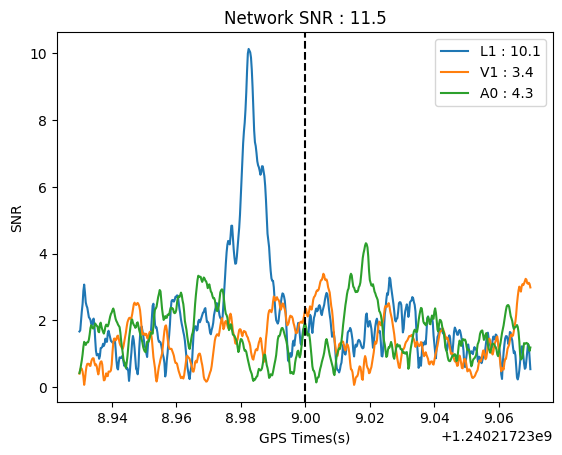

In [13]:
snrs={}
snrs_vals = {}
network_snr = 0

for ifo in ifos:
    
    snrs[ifo] = pycbc.filter.matched_filter(hp, data[ifo], psd=psd[ifo],\
                                            low_frequency_cutoff=fLow, high_frequency_cutoff=fHigh)
    

   #-- around 70 ms from trigger time --
    snrs[ifo] = snrs[ifo].time_slice(start=inject_params['tc'] - 0.07, end=inject_params['tc'] + 0.07)
    
    snrs_vals[ifo] = abs(snrs[ifo]).max()
    
    network_snr += (snrs_vals[ifo])**2
    
    
network_snr = np.sqrt(network_snr)

for ifo in ifos:
    
    plt.plot(snrs[ifo].sample_times, abs(snrs[ifo]), label='%s : %.1f'%(ifo, abs(snrs[ifo]).max()))
   # plt.xlim(inject_params['tc'] - 0.15, inject_params['tc'] + 0.15)

plt.title('Network SNR : %.1f'%network_snr)
plt.xlabel('GPS Times(s)')
plt.axvline(trigTime, ls='--', c='k')
plt.ylabel('SNR')
plt.legend()
#plt.savefig("SNR_4Det_network_test2.jpg", dpi=200, bbox_inches='tight')
plt.show()

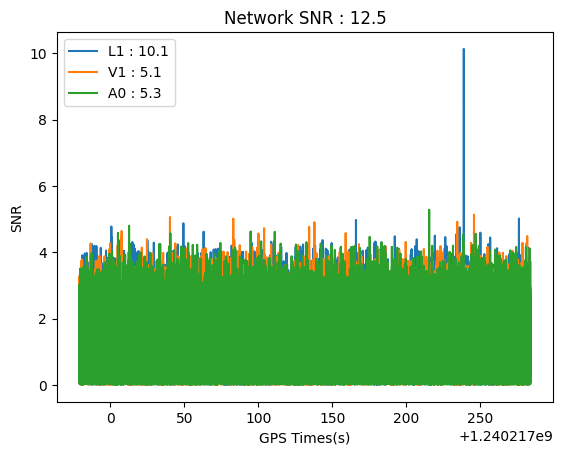

In [27]:
#-- Mistake in SNR calculation --

snrs={}
network_snr = 0

for ifo in ifos:
    
    snrs[ifo] = pycbc.filter.matched_filter(hp, data[ifo], psd=psd[ifo],\
                                            low_frequency_cutoff=fLow, high_frequency_cutoff=fHigh)
    

    snrs[ifo] = snrs[ifo].crop(50,5)
    
    network_snr += (abs(snrs[ifo])**2).max()
    
    
network_snr = np.sqrt(network_snr)

for ifo in ifos:
    
    plt.plot(snrs[ifo].sample_times, abs(snrs[ifo]), label='%s : %.1f'%(ifo, abs(snrs[ifo]).max()))
   # plt.xlim(inject_params['tc'] - 0.15, inject_params['tc'] + 0.15)

plt.title('Network SNR : %.1f'%network_snr)
plt.xlabel('GPS Times(s)')
#plt.axvline(trigTime, ls='--', c='k')
plt.ylabel('SNR')
plt.legend()
#plt.savefig("SNR_4Det_network_test2.jpg", dpi=200, bbox_inches='tight')
plt.show()

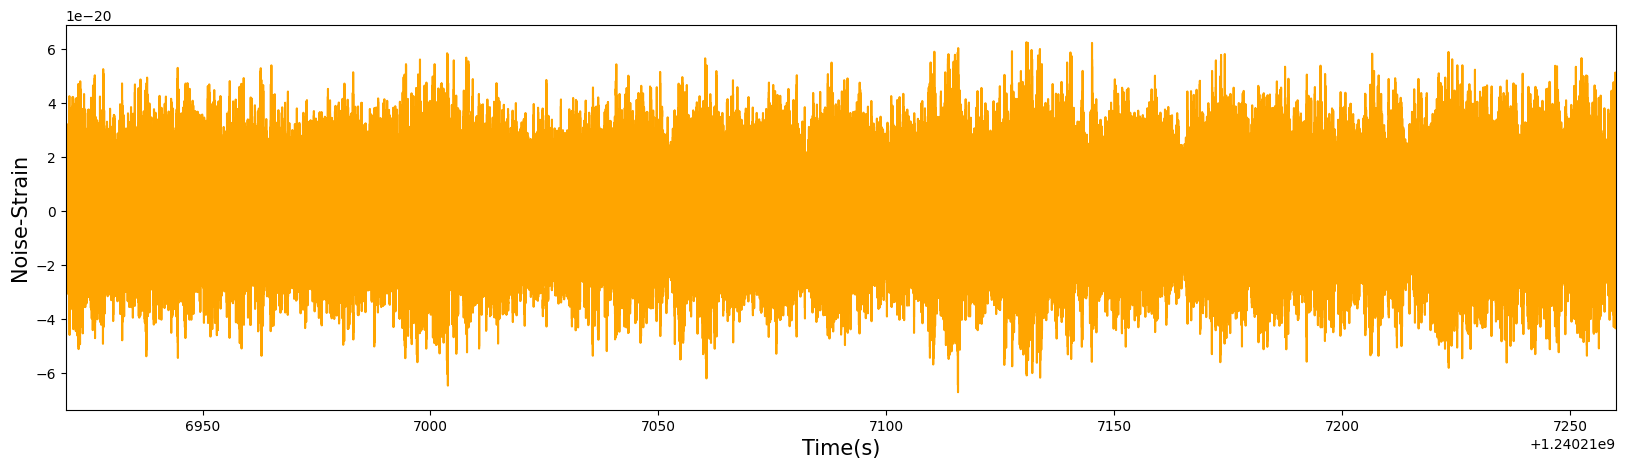

In [14]:
plt.figure(figsize=(20, 5))
fontsize = 15
plt.plot(noise['V1'].sample_times, noise['V1'], c='orange')

plt.xlabel('Time(s)', fontsize=fontsize)
plt.ylabel('Noise-Strain', fontsize=fontsize)
plt.xlim(1.24021e9+6920, 1.24021e9+7260)
plt.savefig("V1_noise.jpg", dpi=200, bbox_inches='tight')
plt.show()